# 1. Library dan Setup

## 1.1 Import Library

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import os
import tensorflow as tf
from google.colab import files, drive
from tensorflow import keras
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, StratifiedKFold
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import swish
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## 1.2 Mount Google Drive

In [ ]:
drive.mount('/content/drive')
base_file_path = "/content/drive/My Drive/Hasil Train LSTM 2/"
if not os.path.exists(base_file_path):
    os.makedirs(base_file_path)

Mounted at /content/drive


## 1.3 Upload Dataset

In [ ]:
uploaded = files.upload()

Saving BooksDataSet.csv to BooksDataSet.csv


# 2. Preprocessing

## 2.1 Membaca Dataset

In [ ]:
books = pd.read_csv('BooksDataSet.csv', sep=';')
books = pd.DataFrame(books, columns=['book_id', 'book_name', 'genre', 'summary'])

## 2.2 Filter Genre dan Membersihkan Data

In [ ]:
selected_genres = ['Crime Fiction', 'Fantasy', 'Historical novel', 'Horror', 'Science Fiction', 'Thriller']
books = books[books['genre'].isin(selected_genres)]
books['summary'] = books['summary'].fillna('').apply(lambda x: x.lower())

<ipython-input-5-e85bda240740>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books['summary'] = books['summary'].fillna('').apply(lambda x: x.lower())


In [ ]:
print("Snapshot of books dataframe")
books

Snapshot of books dataframe


,book_id,book_name,genre,summary
0,3248537,Drowned Wednesday,Fantasy,drowned wednesday is the first trustee among ...
1,27796919,The Lost Hero,Fantasy,"as the book opens, jason awakens on a school ..."
2,3910776,The Eyes of the Overworld,Fantasy,cugel is easily persuaded by the merchant fia...
3,5969644,Magic's Promise,Fantasy,the book opens with herald-mage vanyel return...
4,3173445,Taran Wanderer,Fantasy,taran and gurgi have returned to caer dallben...
...,...,...,...,...
2991,10372180,White Death,Thriller,"a novel from the numa files, a kurt austin ad..."
2992,14504372,Venus with Pistol,Thriller,gilbert kemp is dealer specializing in antiqu...
2993,3617412,Blackwater,Thriller,"""how do you know when you're in too deep? dav..."
2994,11320975,The Rainbow and the Rose,Thriller,the story concerns the life of johnnie pascoe...


In [ ]:
books.groupby('genre').count()

,book_id,book_name,summary
genre,,,
Crime Fiction,499,499,499
Fantasy,498,498,498
Historical novel,499,499,499
Horror,499,499,499
Science Fiction,500,500,500
Thriller,500,500,500


## 2.3 Tokenisasi dan Membersihkan Teks

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemma.lemmatize(word) for word in tokens]
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

books['summary'] = books['summary'].apply(clean_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Menampilkan hasil tokenisasi
print(books['summary'].head())

0    [drown, wednesday, first, truste, among, morro...
1    [book, open, jason, awaken, school, bu, unabl,...
2    [cugel, easili, persuad, merchant, fianosth, a...
3    [book, open, heraldmag, vanyel, return, countr...
4    [taran, gurgi, return, caer, dallben, follow, ...
Name: summary, dtype: object


## 2.4 Label Encoding dan Train-Test Split

In [ ]:
LE = LabelEncoder()
y = LE.fit_transform(books['genre'])
xtrain, xval, ytrain, yval = train_test_split(books['summary'], y, test_size=0.2, random_state=557)

In [ ]:
print("Label encoding:")
print(dict(zip(LE.classes_, range(len(LE.classes_)))))

Label encoding:
{'Crime Fiction': 0, 'Fantasy': 1, 'Historical novel': 2, 'Horror': 3, 'Science Fiction': 4, 'Thriller': 5}


## 2.5 TF-IDF Vectorization

In [ ]:
# Inisialisasi TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
xtrain_tfidf = tfidf_vectorizer.fit_transform([' '.join(text) for text in xtrain])
xval_tfidf = tfidf_vectorizer.transform([' '.join(text) for text in xval])

# Konversi hasil menjadi array
xtrain_tfidf = xtrain_tfidf.toarray()
xval_tfidf = xval_tfidf.toarray()
print(f"xtrain_tfidf shape: {xtrain_tfidf.shape}")
print(f"xval_tfidf shape: {xval_tfidf.shape}")

xtrain_tfidf shape: (2396, 10000)
xval_tfidf shape: (599, 10000)


## 2.6 Word2Vec Vectorization

In [ ]:
# Word2Vec model training
w2v_model = Word2Vec(sentences=books['summary'], vector_size=100, window=5, min_count=1, workers=4)
w2v_model.train(books['summary'], total_examples=w2v_model.corpus_count, epochs=10)

(4732777, 4766140)

In [ ]:
# Word2Vec vektorisasi
def vectorize_text(text, model, vector_size=100):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    else:
        return np.mean(vectors, axis=0)

xtrain_vec = np.array([vectorize_text(text, w2v_model) for text in xtrain])
xval_vec = np.array([vectorize_text(text, w2v_model) for text in xval])

# 3. Model

## 3.1 Membuat Model LSTM

In [ ]:
def modellstm(features, timesteps, num_classes):
    model = Sequential()

    # Bidirectional LSTM
    model.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.3, input_shape=(timesteps, features))))
    model.add(Dropout(0.5))

    # LSTM Layer with Batch Normalization
    model.add(LSTM(128, return_sequences=False, dropout=0.4, recurrent_dropout=0.3))
    model.add(BatchNormalization())

    # Dense Layers with LeakyReLU
    model.add(Dense(256, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation=swish))
    model.add(Dropout(0.4))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile Model with Learning Rate Scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.95
    )
    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


## 3.3 Fungsi Save Model

In [ ]:
def save_trained_model(model, model_name):
    """
    Menyimpan model hasil training ke file HDF5 dengan nama yang sesuai.
    """
    # Path penyimpanan file berdasarkan nama model
    file_path = f"{base_file_path}{model_name}.keras"

    # Simpan model ke file
    model.save(file_path)
    print(f"\n{'-'*50}")
    print(f"Model '{model_name}' has been successfully saved to {file_path}")
    print(f"{'-'*50}\n")

# 4. Pelatihan Model

## 4.1 Train LSTM tanpa K-Fold

In [ ]:
x_train_fold = xtrain_tfidf.reshape((xtrain_tfidf.shape[0], 1, xtrain_tfidf.shape[1]))
x_val_fold = xval_tfidf.reshape((xval_tfidf.shape[0], 1, xval_tfidf.shape[1]))

num_classes = len(np.unique(ytrain))
y_train_fold_enc = to_categorical(ytrain, num_classes=num_classes)
y_val_fold_enc = to_categorical(yval, num_classes=num_classes)

model = modellstm(features=x_train_fold.shape[2], timesteps=1, num_classes=num_classes)
model.fit(x_train_fold, y_train_fold_enc, epochs=100, batch_size=64, validation_data=(x_val_fold, y_val_fold_enc))

# Evaluasi
loss, accuracy = model.evaluate(x_val_fold, y_val_fold_enc)
y_pred_fold = model.predict(x_val_fold)
y_pred_cat = np.argmax(y_pred_fold, axis=1)
y_val_cat = np.argmax(y_val_fold_enc, axis=1)

print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_val_cat, y_pred_cat, target_names=selected_genres))

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.2418 - loss: 3.1509 - val_accuracy: 0.4090 - val_loss: 2.4402
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.6450 - loss: 1.6750 - val_accuracy: 0.2538 - val_loss: 2.0284
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8875 - loss: 0.6370 - val_accuracy: 0.3189 - val_loss: 1.8268
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9660 - loss: 0.2907 - val_accuracy: 0.3740 - val_loss: 1.7028
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.9745 - loss: 0.1943 - val_accuracy: 0.4324 - val_loss: 1.6068
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9777 - loss: 0.1343 - val_accuracy: 0.5075 - val_loss: 1.4935
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9942 - loss: 0.0827 - val_accuracy: 0.5209 - val_loss: 1.4140
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9896 - loss: 0.0750 - val_accuracy: 0.559

### Save Model

In [ ]:
save_trained_model(model, "model LSTM tanpa k-fold")


--------------------------------------------------
Model 'model LSTM tanpa k-fold' has been successfully saved to /content/drive/My Drive/Hasil Train LSTM 2/model LSTM tanpa k-fold.keras
--------------------------------------------------




## 4.2 Train LSTM dengan K-Fold Cross Validation

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=557)

accuracy_scores = []

# Loop untuk setiap fold
for train_index, val_index in kfold.split(xtrain_tfidf, ytrain):
    x_train_fold, x_val_fold = xtrain_tfidf[train_index], xtrain_tfidf[val_index]
    y_train_fold, y_val_fold = ytrain[train_index], ytrain[val_index]

    # Reshape untuk LSTM
    x_train_fold = x_train_fold.reshape((x_train_fold.shape[0], 1, x_train_fold.shape[1]))
    x_val_fold = x_val_fold.reshape((x_val_fold.shape[0], 1, x_val_fold.shape[1]))

    # One-hot encoding label
    y_train_fold_enc = to_categorical(y_train_fold, num_classes=num_classes)
    y_val_fold_enc = to_categorical(y_val_fold, num_classes=num_classes)

    # Inisialisasi model LSTM
    model = modellstm(features=x_train_fold.shape[2], timesteps=1, num_classes=num_classes)
    model.fit(x_train_fold, y_train_fold_enc, epochs=75, batch_size=64, verbose=1, validation_data=(x_val_fold, y_val_fold_enc))

    # Evaluasi model
    loss, accuracy = model.evaluate(x_val_fold, y_val_fold_enc)
    accuracy_scores.append(accuracy)

    # Prediksi dan hitung F1 score
    y_pred_fold = model.predict(x_val_fold)
    y_pred_cat = np.argmax(y_pred_fold, axis=1)
    y_val_cat = np.argmax(y_val_fold_enc, axis=1)

print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")

Epoch 1/75


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.2225 - loss: 3.2035 - val_accuracy: 0.1917 - val_loss: 2.5242
Epoch 2/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.6607 - loss: 1.8497 - val_accuracy: 0.3417 - val_loss: 2.0843
Epoch 3/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.8842 - loss: 0.7266 - val_accuracy: 0.3417 - val_loss: 1.8809
Epoch 4/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9441 - loss: 0.3765 - val_accuracy: 0.2958 - val_loss: 1.7531
Epoch 5/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9848 - loss: 0.1924 - val_accuracy: 0.2958 - val_loss: 1.6753
Epoch 6/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9920 - loss: 0.1189 - val_accuracy: 0.4250 - val_loss: 1.5688
Epoch 7/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9918 - loss: 0.0905 - val_accuracy: 0.4667 - val_loss: 1.4922
Epoch 8/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9957 - loss: 0.0649 - val_accuracy: 0.5125 - val_los

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Epoch 1/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.2536 - loss: 3.1882 - val_accuracy: 0.1708 - val_loss: 2.5157
Epoch 2/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.6200 - loss: 1.8898 - val_accuracy: 0.4000 - val_loss: 2.0944
Epoch 3/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.8898 - loss: 0.6923 - val_accuracy: 0.4458 - val_loss: 1.8738
Epoch 4/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9630 - loss: 0.3332 - val_accuracy: 0.5167 - val_loss: 1.7422
Epoch 5/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9874 - loss: 0.1794 - val_accuracy: 0.4667 - val_loss: 1.6453
Epoch 6/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.9922 - loss: 0.1271 - val_accuracy: 0.5250 - val_loss: 1.5536
Epoch 7/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.9911 - loss: 0.0888 - val_accuracy: 0.6083 - val_loss: 1.4476
Epoch 8/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Epoch 1/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.2371 - loss: 3.1963 - val_accuracy: 0.2208 - val_loss: 2.5188
Epoch 2/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6945 - loss: 1.8992 - val_accuracy: 0.2000 - val_loss: 2.0879
Epoch 3/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8831 - loss: 0.7190 - val_accuracy: 0.1958 - val_loss: 1.9004
Epoch 4/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9517 - loss: 0.3619 - val_accuracy: 0.2083 - val_loss: 1.7981
Epoch 5/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9838 - loss: 0.1894 - val_accuracy: 0.2208 - val_loss: 1.7007
Epoch 6/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9890 - loss: 0.1277 - val_accuracy: 0.3083 - val_loss: 1.6129
Epoch 7/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9927 - loss: 0.0927 - val_accuracy: 0.4000 - val_loss: 1.5325
Epoch 8/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.995

### Save Model

In [ ]:
save_trained_model(model, "model LSTM K-Fold")


--------------------------------------------------
Model 'model LSTM K-Fold' has been successfully saved to /content/drive/My Drive/Hasil Train LSTM 2/model LSTM K-Fold.keras
--------------------------------------------------



# 5. Evaluasi

## 5.1 Fungsi Untuk Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, target_names, title="Confusion Matrix"):
    """
    Menampilkan confusion matrix dengan penataan yang lebih rapi.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names,
                cbar=False, annot_kws={"size": 12})
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 5.2 Fungsi Untuk Plot Classification Matrix

In [ ]:
def plot_classification_metrics(y_true, y_pred, target_names):
    """
    Menampilkan bar plot untuk Precision, Recall, F1, dan Akurasi per kelas.
    """
    # Hitung metrik utama
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)

    # Menghitung akurasi per kelas
    cm = confusion_matrix(y_true, y_pred)  # Matriks kebingungannya
    class_accuracy = cm.diagonal() / cm.sum(axis=1)  # True Positives / Jumlah per kelas

    # Membuat dataframe untuk plot
    metrics_df = pd.DataFrame({
        'Accuracy': class_accuracy,  # Akurasi per kelas
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }, index=target_names)

    # Membuat bar plot
    ax = metrics_df.plot(kind='bar', figsize=(12, 6), width=0.8, color = ['#7fbbff', '#4c8fbc', '#2e6a8e', '#1f3a5a'], fontsize=12)

    # Menambahkan title dan label
    ax.set_title("Precision, Recall, F1 Score, and Accuracy per Class", fontsize=14)
    ax.set_xlabel('Classes', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xticklabels(target_names, rotation=45)
    ax.legend(title="Metrics", fontsize=12)

    # Menampilkan angka di atas setiap bar dengan format 0.00
    for container in ax.containers:
        ax.bar_label(container, label_type='edge', fontsize=10, color='black', padding=3, fmt='%.2f')

    # Rapi layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Memberikan ruang untuk teks akurasi
    plt.show()


## 5.3 Fungsi Untuk Memuat dan Mengevaluasi Model

In [ ]:
def load_and_evaluate_model_on_train(model_name, x_train, y_train_enc, target_names):
    """
    Meload model dari file Keras, melakukan evaluasi pada data train, dan mencetak nilai tertinggi.
    """
    # Path file model
    file_path = f"{base_file_path}{model_name}.keras"

    # Load model
    model = keras.models.load_model(file_path)
    print(f"\n{'-'*50}")
    print(f"Model '{model_name}' loaded successfully from {file_path}")
    print(f"{'-'*50}\n")

    # Evaluasi model pada data train
    loss, accuracy = model.evaluate(x_train, y_train_enc, verbose=0)

    # Prediksi
    y_pred = model.predict(x_train)
    y_pred_cat = np.argmax(y_pred, axis=1)
    y_train_cat = np.argmax(y_train_enc, axis=1)

    # Hitung metrik
    precision = precision_score(y_train_cat, y_pred_cat, average="macro")
    recall = recall_score(y_train_cat, y_pred_cat, average="macro")
    f1 = f1_score(y_train_cat, y_pred_cat, average="macro")

    # Tampilkan hasil evaluasi
    print(f"/nEvaluation results for model '{model_name}' on training data:\n")
    print(f"Highest Accuracy: {accuracy:.4f}")
    print(f"Highest Precision: {precision:.4f}")
    print(f"Highest Recall: {recall:.4f}")
    print(f"Highest F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_train_cat, y_pred_cat, target_names=target_names))
    print(f"{'-'*50}\n")

    # Plotting
    plot_confusion_matrix(y_train_cat, y_pred_cat, target_names)
    print("\n\n")
    plot_classification_metrics(y_train_cat, y_pred_cat, target_names)


## 5.4 Evaluasi Model LSTM


--------------------------------------------------
Model 'model LSTM tanpa k-fold' loaded successfully from /content/drive/My Drive/Hasil Train LSTM 2/model LSTM tanpa k-fold.keras
--------------------------------------------------

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
/nEvaluation results for model 'model LSTM tanpa k-fold' on training data:

Highest Accuracy: 0.6444
Highest Precision: 0.6410
Highest Recall: 0.6386
Highest F1 Score: 0.6362

Classification Report:
                  precision    recall  f1-score   support

   Crime Fiction       0.66      0.75      0.70       109
         Fantasy       0.60      0.49      0.54        89
Historical novel       0.66      0.66      0.66        97
          Horror       0.67      0.54      0.60       107
 Science Fiction       0.66      0.79      0.72       107
        Thriller       0.59      0.59      0.59        90

        accuracy                           0.64       599
       macro avg       0.64      0.64      0.64       599
   

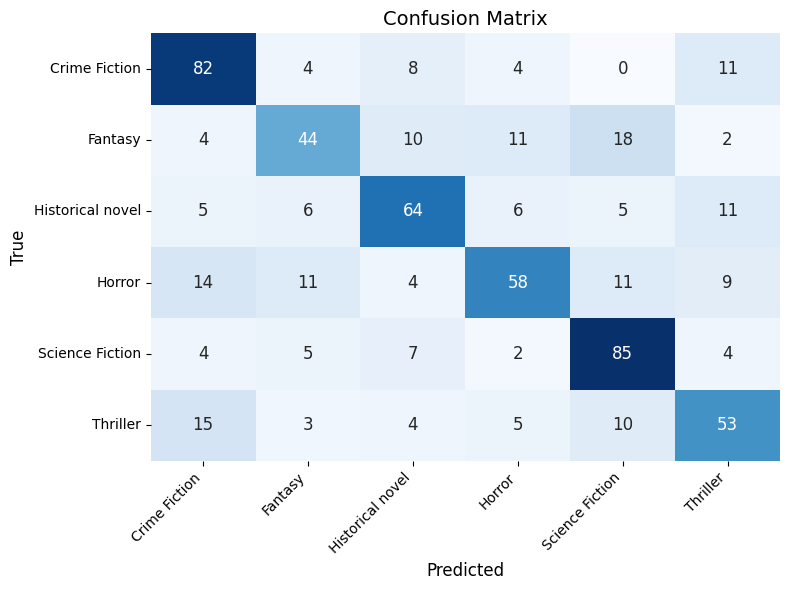

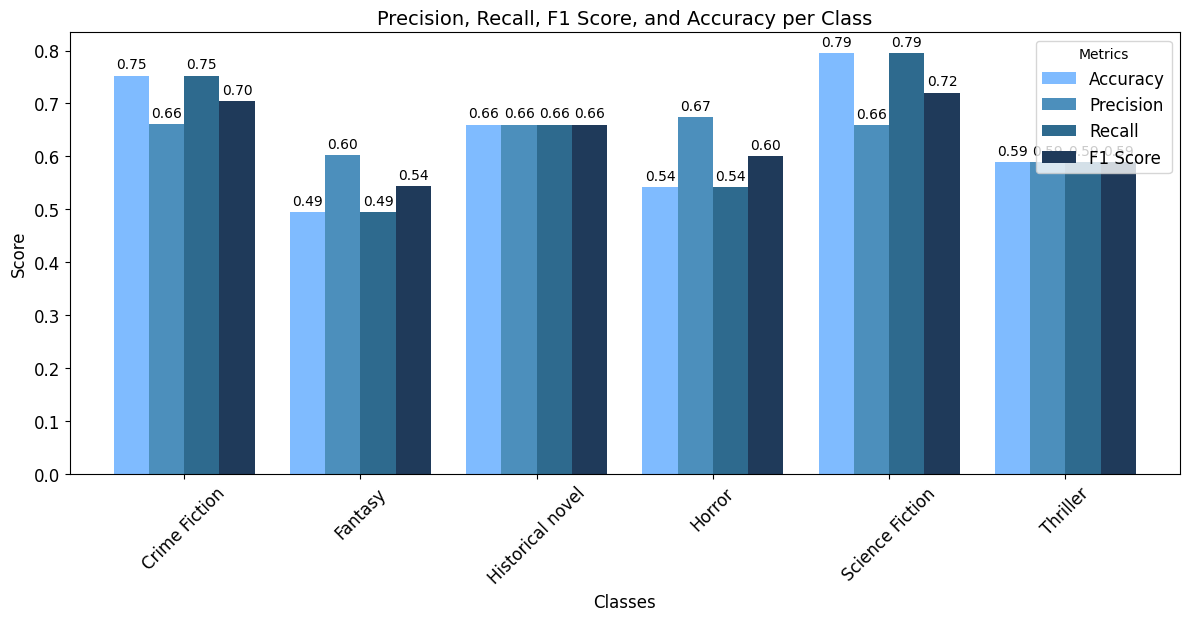

In [ ]:
load_and_evaluate_model_on_train("model LSTM tanpa k-fold", x_val_fold, y_val_fold_enc, selected_genres)

## 5.5 Evaluasi Model LSTM + K-Fold


--------------------------------------------------
Model 'model LSTM K-Fold' loaded successfully from /content/drive/My Drive/Hasil Train LSTM 2/model LSTM K-Fold.keras
--------------------------------------------------

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
/nEvaluation results for model 'model LSTM K-Fold' on training data:

Highest Accuracy: 0.6569
Highest Precision: 0.6707
Highest Recall: 0.6565
Highest F1 Score: 0.6601

Classification Report:
                  precision    recall  f1-score   support

   Crime Fiction       0.74      0.67      0.70        39
         Fantasy       0.65      0.68      0.67        41
Historical novel       0.57      0.60      0.59        40
          Horror       0.66      0.59      0.62        39
 Science Fiction       0.84      0.69      0.76        39
        Thriller       0.56      0.71      0.62        41

        accuracy                           0.66       239
       macro avg       0.67      0.66      0.66       239
    weighted avg       

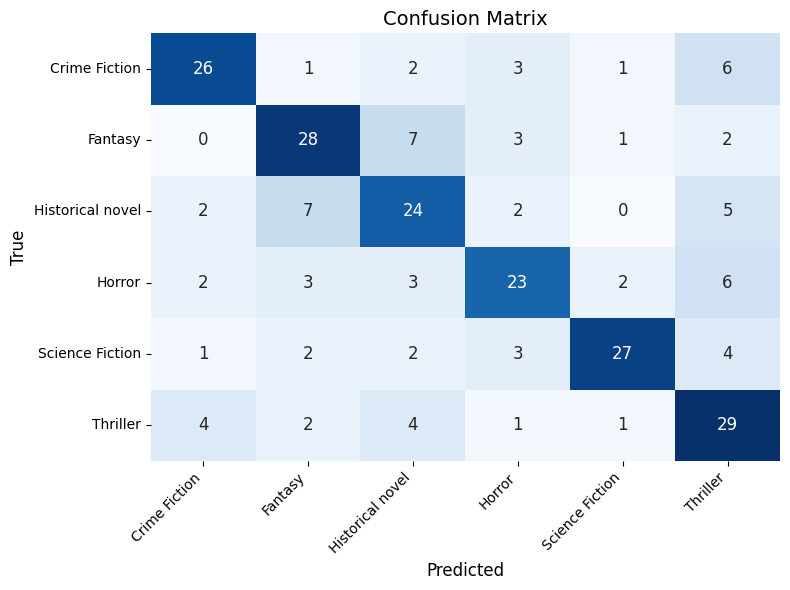

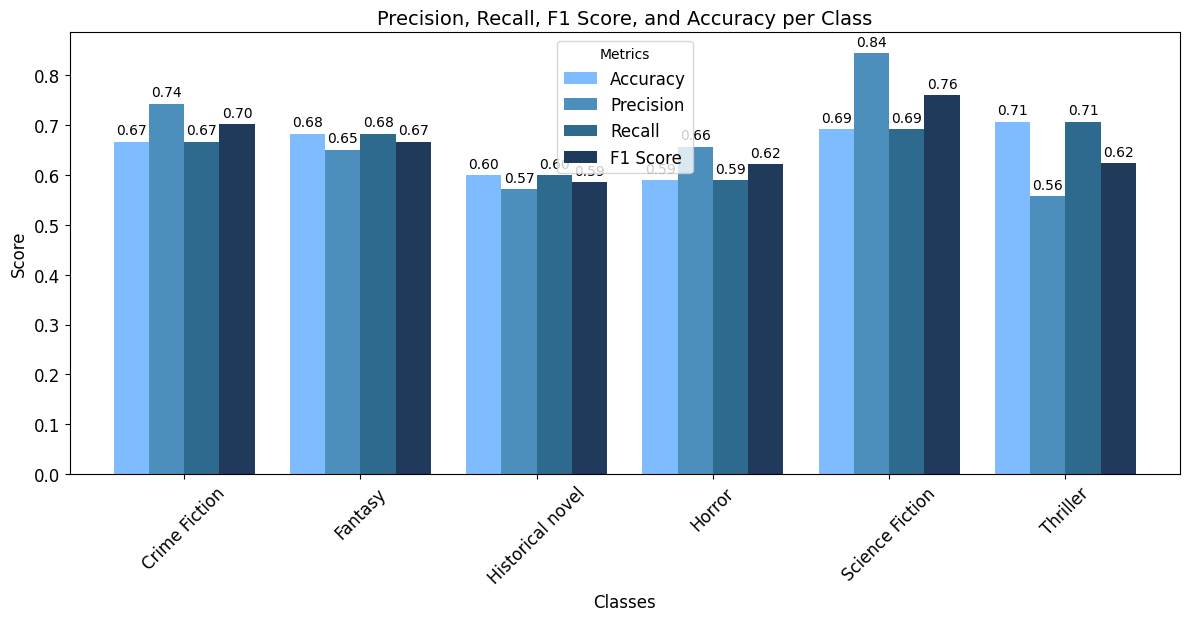

In [ ]:
load_and_evaluate_model_on_train("model LSTM K-Fold", x_val_fold, y_val_fold_enc, selected_genres)